In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import sys

plt.rcParams["figure.figsize"] = (8, 8)

In [47]:
sys.path.append('../utils')  

from utils import residual_plot

## Loading data

In [48]:
# import
data = pd.read_csv('..\data\data.csv', sep=';',
                   index_col='Unnamed: 0', encoding='cp1251')

# rename some columns for readability
rename_dict = {
    '@NTG@': 'NTG',
    '@RVAR@': 'Lsand',
    '@PERMX@': 'perm',
    'КИН (100)': 'ORF100'
}
data.rename(columns=rename_dict, inplace=True)

print(data.shape)

(124416, 17)


In [49]:
data.columns

Index(['PORO', 'SW', 'KRW', 'system_number', 'NTG', 'Lsand', 'perm', 'l_horiz',
       'param_x', 'param_y', 'n_frac', 'xf_prod', 'xf_inj', 'rotation_angle',
       'switch_period', 'dFrac', 'ORF100'],
      dtype='object')

In [50]:
seed=42

In [51]:
categorical_cols = [
    'system_number',
    'rotation_angle'
]

numerical_cols = [
    'NTG',
    'Lsand',
    'perm',
    'l_horiz',
    'param_x',
    'n_frac',
    'xf_prod',
    'xf_inj',
    'switch_period',
    'dFrac'
]


cols_to_drop = [
    'PORO',
    'SW',
    'KRW',
    'param_y'
]

# Setting up models

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=cols_to_drop + ['ORF100']),
    data['ORF100'],
    test_size=0.2,
    random_state=42
)

In [53]:
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [54]:
model_dict = {}

## Pipeline with linear regression

In [55]:
from sklearn.linear_model import Ridge

In [74]:
linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(alpha=0.1))
])

model_dict['linreg'] = linear_regression

linear_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['NTG', 'Lsand', 'perm',
                                                   'l_horiz', 'param_x',
                                                   'n_frac', 'xf_prod',
                                                   'xf_inj', 'switch_period',
                                                   'dFrac']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['system_number',
                                                   'rotation_angle'])])),
                ('ridge', Ridge(alpha=0.1))])

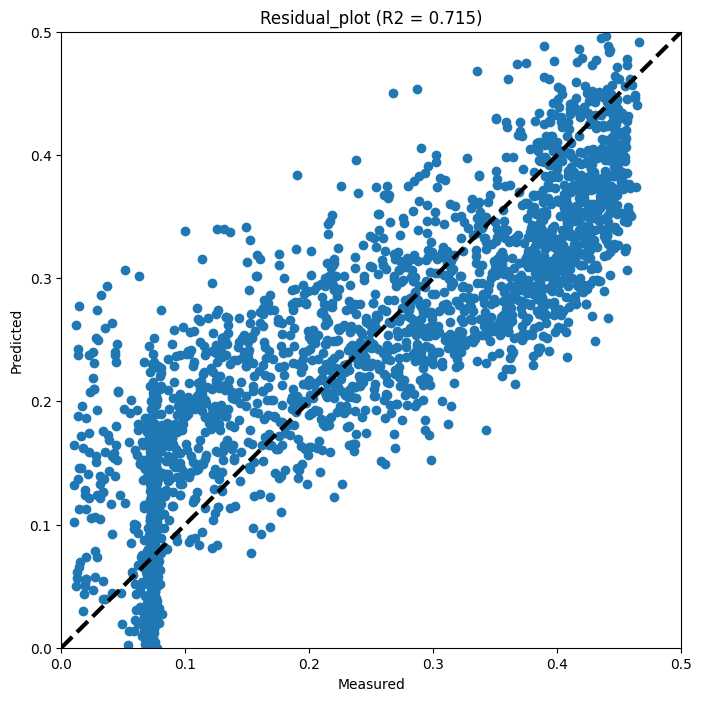

In [75]:
residual_plot(y_test, linear_regression.predict(X_test), linear_regression.score(X_test, y_test).round(3))

## SVM pipeline

In [58]:
from sklearn.svm import SVR

svm_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('SVR', SVR(C=10))
])

model_dict['SVM'] = svm_regression

svm_regression.fit(
    X_train,
    y_train
)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['NTG', 'Lsand', 'perm',
                                                   'l_horiz', 'param_x',
                                                   'n_frac', 'xf_prod',
                                                   'xf_inj', 'switch_period',
                                                   'dFrac']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['system_number',
                                                   'rotation_angle'])])),
                ('SVR', SVR(C=10))])

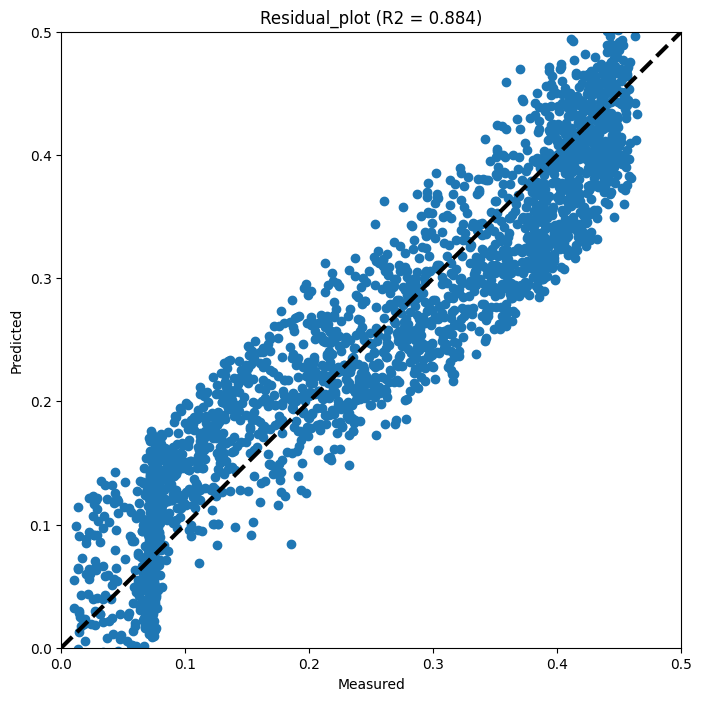

In [59]:
residual_plot(
    y_test,
    svm_regression.predict(X_test),
    svm_regression.score(X_test, y_test)
)

## Catboost pipeline

In [60]:
from catboost import CatBoostRegressor

In [129]:
catboost_model = CatBoostRegressor(
    cat_features=categorical_cols,
    l2_leaf_reg=1,
    depth=6,
    learning_rate=0.3,
    iterations=3000,
    verbose=False
)

catboost_regression = Pipeline([
    ('Catboost', catboost_model)
])

model_dict['Catboost'] = catboost_regression

catboost_regression.fit(X_train, y_train)

Pipeline(steps=[('Catboost',
                 <catboost.core.CatBoostRegressor object at 0x0000017C3E4151E0>)])

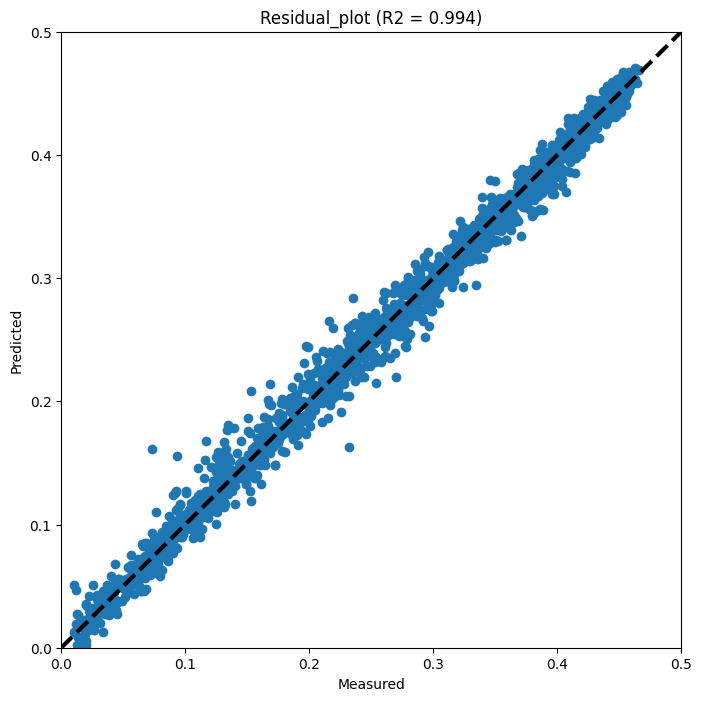

In [130]:
residual_plot(y_test, catboost_regression.predict(X_test), catboost_regression.score(X_test, y_test))

## KNN pipeline

In [63]:
from sklearn.neighbors import KNeighborsRegressor
knn_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('KNN', KNeighborsRegressor(n_neighbors=20, p=1, weights='distance', n_jobs=-1,))
])

model_dict['KNN'] = knn_regression

knn_regression.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['NTG', 'Lsand', 'perm',
                                                   'l_horiz', 'param_x',
                                                   'n_frac', 'xf_prod',
                                                   'xf_inj', 'switch_period',
                                                   'dFrac']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['system_number',
                                                   'rotation_angle'])])),
                ('KNN',
                 KNeighborsRegressor(n_jobs=-1, n_neighbors=20, p=1,
                                     weights='distance'))])

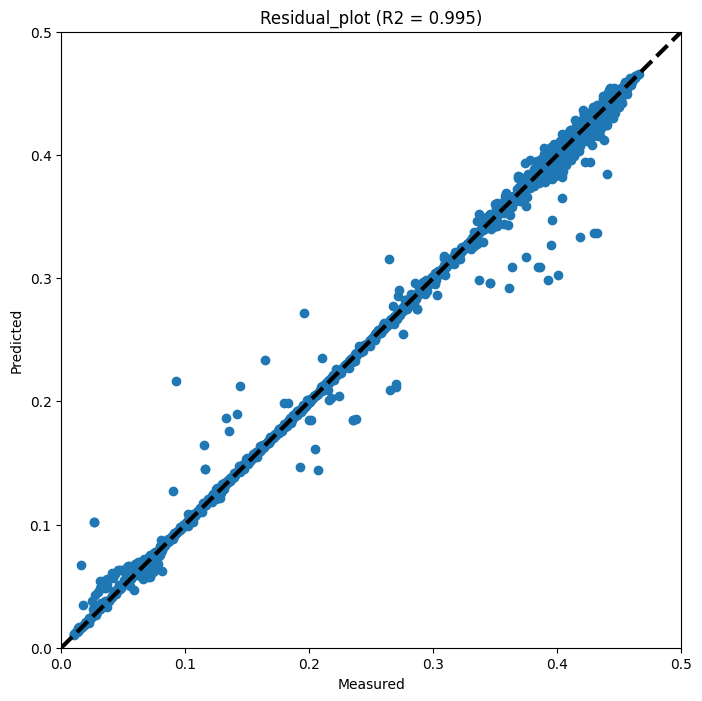

In [64]:
residual_plot(
    y_test,
    knn_regression.predict(X_test),
    knn_regression.score(X_test, y_test)
)

## Random forest pipeline

In [65]:
from sklearn.ensemble import RandomForestRegressor
random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('Random_forest', RandomForestRegressor(n_jobs=-1))
])

model_dict['Random Forest'] = random_forest

random_forest.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['NTG', 'Lsand', 'perm',
                                                   'l_horiz', 'param_x',
                                                   'n_frac', 'xf_prod',
                                                   'xf_inj', 'switch_period',
                                                   'dFrac']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['system_number',
                                                   'rotation_angle'])])),
                ('Random_forest', RandomForestRegressor(n_jobs=-1))])

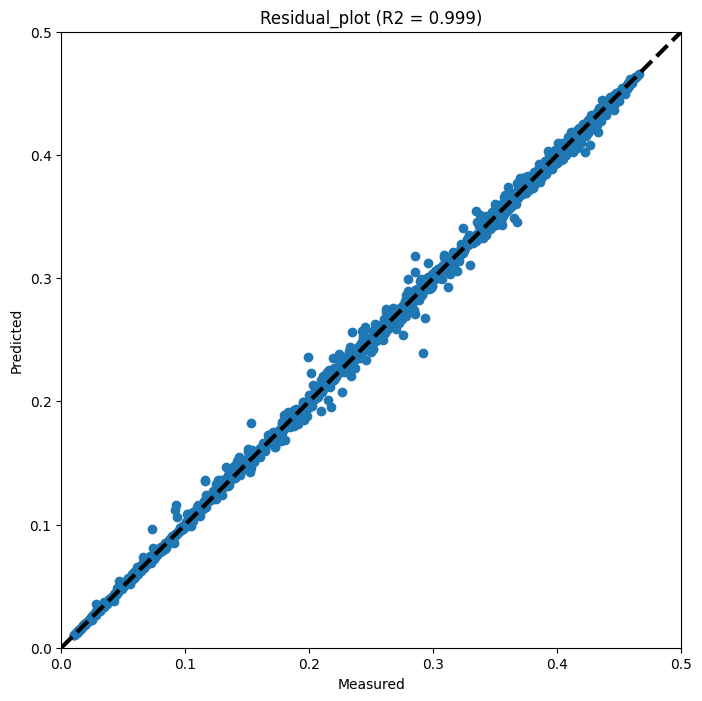

In [66]:
residual_plot(y_test, random_forest.predict(X_test), random_forest.score(X_test, y_test))

## Neural Network pipeline

In [149]:
import torch
import torch.nn as nn

class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)


In [150]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from torch.utils.data import DataLoader, TensorDataset


class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, optimizer, loss_fn, epochs=100, batch_size=1024, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32).to(self.device)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for X_batch, y_batch in dataloader:
                self.optimizer.zero_grad()
                y_pred = self.model(X_batch).squeeze()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            y_pred = self.model(X)
        return y_pred.cpu().numpy().ravel()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)


In [151]:
input_size = 21  # The number of input features
hidden_size = 64  # The number of neurons in the hidden layer
output_size = 1 
batch_size = 8192
num_epochs = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the PyTorch MLP Regressor
mlp_regressor = MLPRegressor(input_size, hidden_size, output_size)

# Instantiate the custom PyTorchRegressor wrapper
optimizer = torch.optim.Adam(mlp_regressor.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
pytorch_regressor = PyTorchRegressor(
    mlp_regressor, 
    optimizer, 
    loss_fn, 
    batch_size=batch_size, 
    epochs=num_epochs,
    device=device
    )



In [152]:
# Create the pipeline with the custom wrapper
neural_network = Pipeline([
    ('preprocessor', preprocessor),
    ('MLP', pytorch_regressor)
])

model_dict['MLP'] = neural_network

neural_network.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['NTG', 'Lsand', 'perm',
                                                   'l_horiz', 'param_x',
                                                   'n_frac', 'xf_prod',
                                                   'xf_inj', 'switch_period',
                                                   'dFrac']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['system_number',
                                                   'rotation_angle'])])),
                ('MLP',
                 PyTorchRegressor(batch_size=8192, loss_fn=MSELoss(),
                                  model=MLPRegressor(
  (layers): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
),
                                  optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)))])

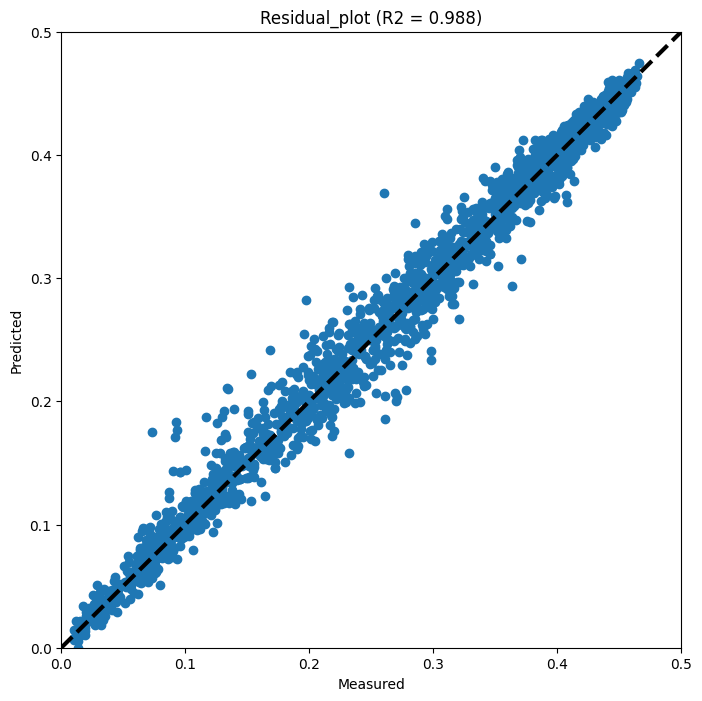

In [153]:
residual_plot(y_test, neural_network.predict(X_test), neural_network.score(X_test, y_test))

# Fitting models on subsamples of data

In [114]:
def partial_data_preds(data, pipeline, num_models, seed=42):
    '''Train given regressor or pipeline on subsamples of data.

    Takes a Pandas DataFrame, regressor or a pipeline, number of
    models to fit on a subsample of data and a random seed

    Returns a dictionary with data fraction as the key, and a tuple containing 
    true and predicted target values as numpy arrays and r2 score value;
    also returns numpy array of all model scores'''

    results = {}
    scores = []

    # Extract the regressor name from the pipeline
    regressor_name = list(pipeline.named_steps.keys())[-1]

    for i in np.linspace(0 + 1/num_models, 1, num_models):

        data_sample = data.sample(
            frac=i,
            random_state=seed,
            ignore_index=True
        )

        X_train, X_test, y_train, y_test = train_test_split(
            data_sample.drop(columns=cols_to_drop + ['ORF100']),
            data_sample['ORF100'],
            test_size=0.2,
            random_state=seed
        )

        pipeline.fit(X_train, y_train)
        # Reset index for y_test
        y_test = y_test.reset_index(drop=True).rename(
            f'true_ORF100_{i.round(2)}')
        y_pred = pd.Series(pipeline.predict(X_test),
                           name=f'{regressor_name}_pred_{i.round(2)}')

        # Convert true and predicted values to numpy arrays
        y_test_np = y_test.to_numpy()
        y_pred_np = y_pred.to_numpy()
        
        score = pipeline.score(X_test, y_test).round(3)
        
        results[i.round(2)] = (y_test_np, y_pred_np, score)
        scores.append([i.round(2), pipeline.score(
            X_test, y_test).round(3)])
        
    return results, np.array(scores)


In [127]:
model_dict.keys()

dict_keys(['linreg', 'SVM', 'Catboost', 'KNN', 'Random Forest', 'MLP'])

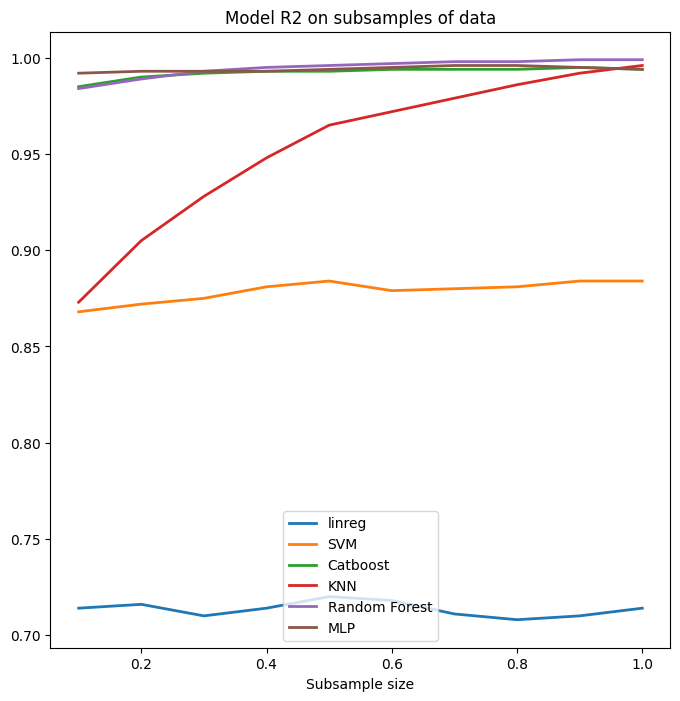

In [162]:
all_preds = {}

# Initialize the plot
fig, ax = plt.subplots()
plt.title('Model R2 on subsamples of data')

# Loop through the models and plot the results
for label, model in model_dict.items():
    preds, score = partial_data_preds(data, model, 10)
    all_preds[label] = preds  # Save preds to the all_preds dictionary
    ax.plot(score[:, 0], score[:, 1], label=label, linewidth=2)

# Configure plot appearance and display
plt.legend()
plt.xlabel('Subsample size')
plt.show()

We can also check residual plots for each prediction:

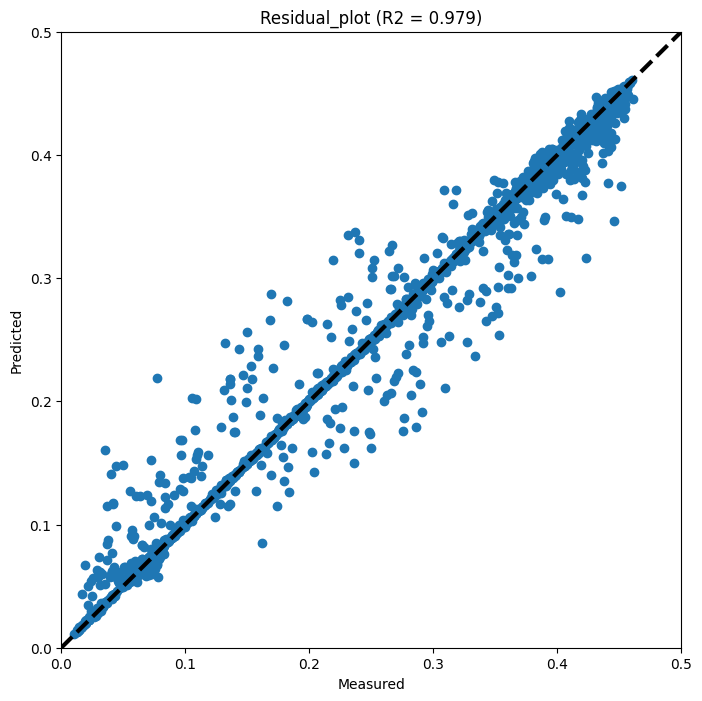

In [169]:
residual_plot(
    all_preds['KNN'][0.7][0],
    all_preds['KNN'][0.7][1],
    all_preds['KNN'][0.7][2],
    marks=7
)

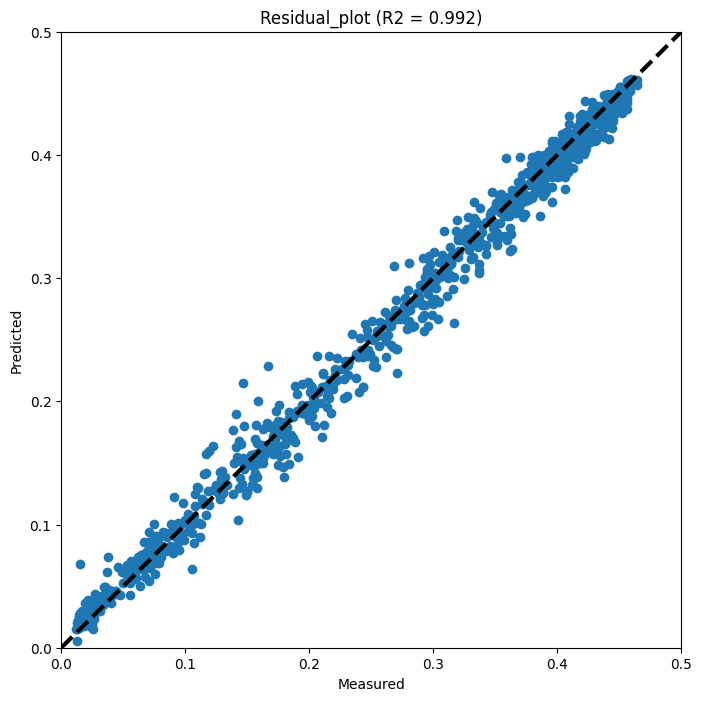

In [167]:
residual_plot(
    all_preds['MLP'][0.1][0],
    all_preds['MLP'][0.1][1],
    all_preds['MLP'][0.1][2],
    marks=1
)